In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')

In [2]:
dataset_path = "../../dataset"
preprocessed_dataset_path = "preprocessed_dataset/"

In [3]:
from codes.docs.analysis.nimagen import stats, visualisation
from codes.docs.analysis import data_preprocessing

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import nibabel as nib

## Imperial atlas

In [5]:
lobe_only_legend = {int(k.replace('Imperial ','')):v['abbr'] for k,v in data_preprocessing.Volumes.Imperial.get_Imperial_legends(grouping=['lobe','hemisphere','gmwm2gether']).items() if v['abbr'] is not None}

In [6]:
plot_val = {k:p for k,p in zip(range(1,88),np.random.random(87))}

In [7]:
mask = {k:p for k,p in zip(range(1,88),np.random.random(87))}

In [8]:
lobe_only_val = {k:1 if v=='temporal' else 2 if v=='occipital' else 3 if v=='parietal' else 4 for k,v in lobe_only_legend.items()}

In [9]:
remove_regions = [int(k.replace('Imperial ','')) for k,v in data_preprocessing.Volumes.Imperial.get_Imperial_legends(grouping=['lobe','hemisphere','gmwm2gether']).items() if v['abbr'] is None]

In [10]:
lobe_only_legend_colours = {k:'yellow' if v=='temporal' else 'red' if v=='occipital' else 'blue' if v=='parietal' else 'purple' for k,v in lobe_only_legend.items()}

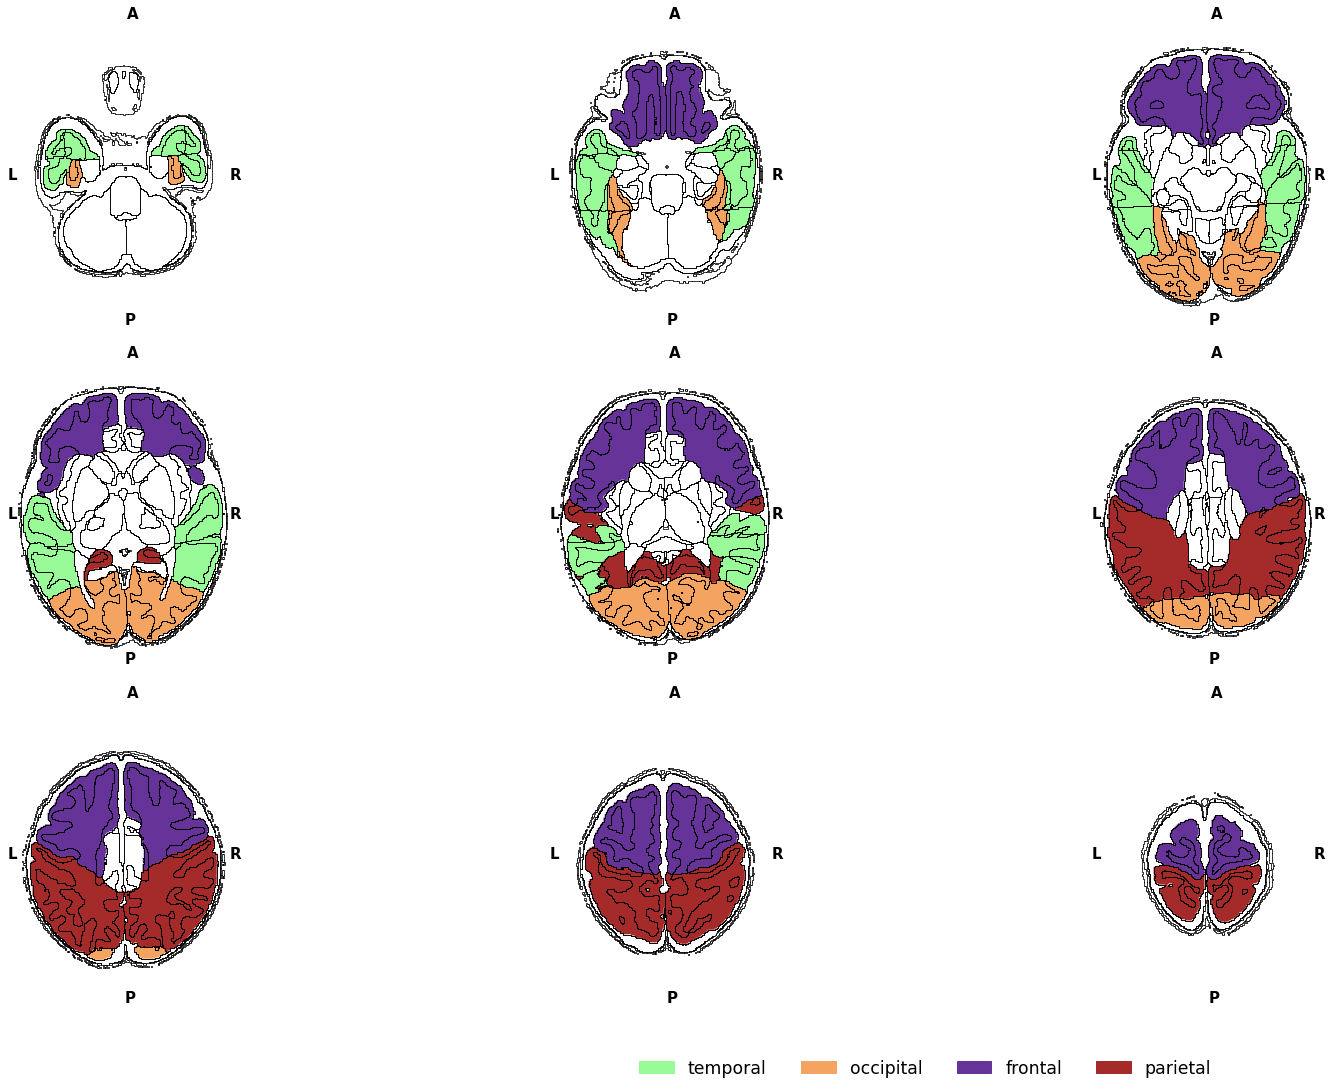

In [12]:
atlas_slices = [int(i) for i in np.linspace(50,180,9)]
fig,axes = plt.subplots(3,3,figsize=(20,15))
axes = axes.flatten()
for ax,atlas_slice in zip(axes,atlas_slices):
    if atlas_slice == 115:
            _,brainmap = visualisation.Brainmap.plot_segmentation(
            atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
            map_view=['axial'],
            atlas_slice = atlas_slice,
            label_legend=lobe_only_legend,
            outline_label_legends=False,
            axes=ax,fig=fig,
            legends=True,
            label_legend_bbox_to_anchor=(-2.0,-0.25,0,0),
            label_legend_fontsize='xx-large')
    else:
        _,_ = visualisation.Brainmap.plot_segmentation(
            atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
            map_view=['axial'],
            label_legend=lobe_only_legend,
            outline_label_legends=False,
            atlas_slice = atlas_slice,
            axes=ax,
            legends=False)

plt.tight_layout()
plt.savefig('../../../nimagen/docs/example/images/brain_legend_full.png')

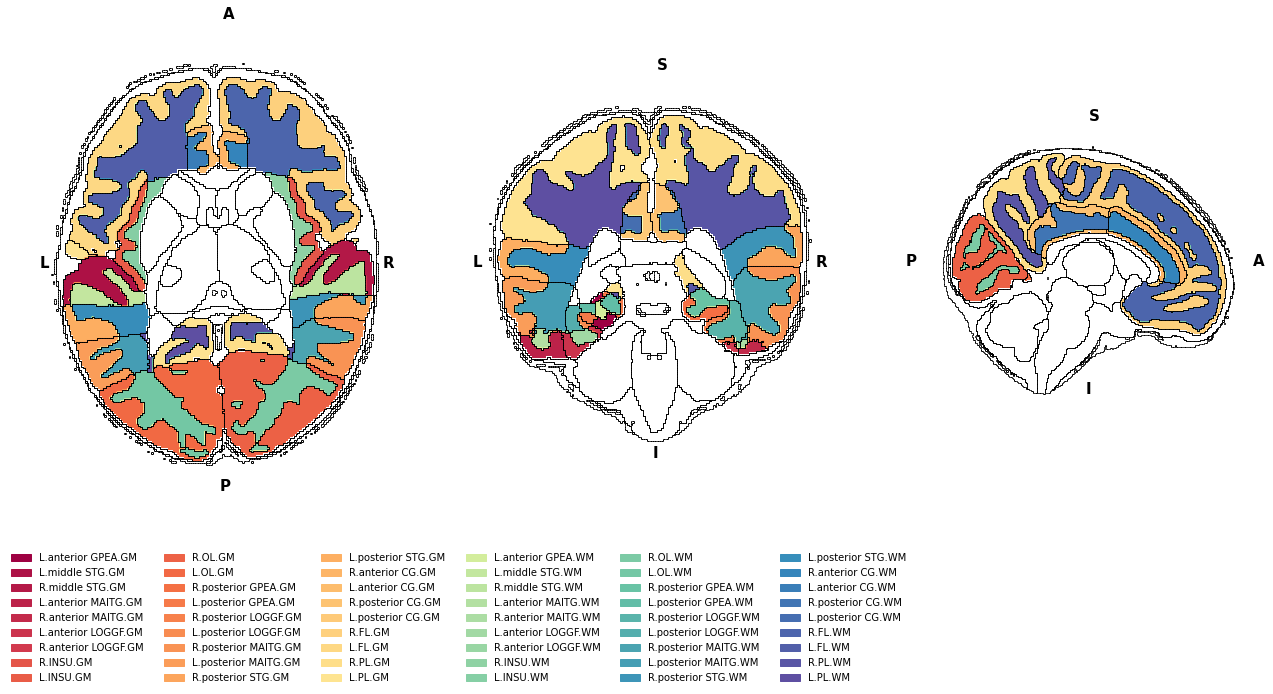

In [15]:
fig,map_view_dict_Imperial = visualisation.Brainmap.plot_segmentation(map_view=['all'],regions_to_hide=deep_grey_matter_labels+lateral_ventricles_labels+brainstem_labels+csf_labels+background_labels+corpus_callosum_labels+cerebellum_labels,label_legend=label_legend,atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',plot_orientation=True,outline_label_legends=True,outline_regions_to_hide=False)
# fig.savefig('segmentation.svg',format='svg')

In [109]:
european_volumetric_dataset_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

european_volumetric_dataset_term = european_volumetric_dataset_term[(european_volumetric_dataset_term['radiology_score']<5)&(european_volumetric_dataset_term['radiology_low_image_quality']==False)]

df = european_volumetric_dataset_term.copy()

ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers

df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)

df = df.drop(columns=['ASD_PRS_Pt_1e-07'])

pca, prs_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
    df,
    dependentVar_cols=[i for i in df.columns if 'ASD_PRS' in i],
    scaling=True,
    n_components=1
)

df['PRS_pca'] = prs_pca

new_df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=['lobe','hemisphere','gmwm2gether'])

new_df['Frontal lobe TTV'] = new_df['Imperial 36']
new_df['Parietal lobe TTV'] = new_df['Imperial 38']
new_df['Occipital lobe TTV'] = new_df['Imperial 15']
new_df['Temporal lobe TTV'] = new_df['Imperial 5']

# new_df['Frontal+Parietal TTV'] = new_df['Frontal lobe TTV'] + new_df['Parietal lobe TTV']
# new_df['Frontal+Occipital TTV'] = new_df['Frontal lobe TTV'] + new_df['Occipital lobe TTV']
new_df['Frontal+Temporal TTV'] = new_df['Frontal lobe TTV'] + new_df['Temporal lobe TTV']
new_df['Parietal+Occipital TTV'] = new_df['Parietal lobe TTV'] + new_df['Occipital lobe TTV']
# new_df['Parietal+Temporal TTV'] = new_df['Parietal lobe TTV'] + new_df['Temporal lobe TTV']
# new_df['Occipital+Temporal TTV'] = new_df['Temporal lobe TTV'] + new_df['Occipital lobe TTV']


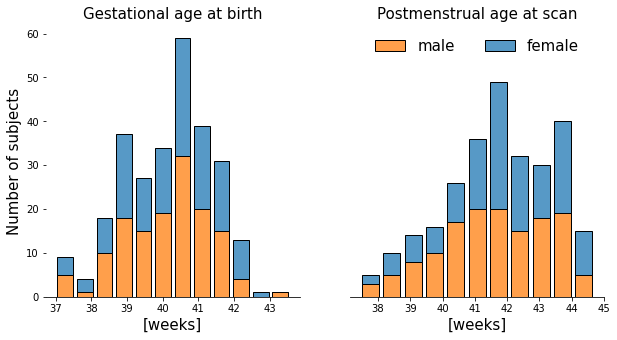

In [228]:
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams["axes.grid.axis"] ="y"
sns.set_style('whitegrid')
sns.reset_orig()
fig,axes = plt.subplots(1,2,sharey=True,figsize=(10,5))
sns.histplot(data=new_df,x='GA',shrink=.8,hue='sex',multiple='stack',ax=axes[0])
sns.histplot(data=new_df,x='PMA',shrink=.8,hue='sex',multiple='stack',ax=axes[1])
axes[0].set_title('Gestational age at birth',fontsize=15)
axes[1].set_title('Postmenstrual age at scan',fontsize=15)
axes[0].set_ylabel('Number of subjects',fontsize=15)
axes[0].set_xlabel('[weeks]',fontsize=15)
axes[1].set_xlabel('[weeks]',fontsize=15)
sns.despine(left=True)
axes[0].legend([],[],frameon=False)
# axes[1].legend(['male','female'],ncol=2,loc='upper center',fontsize=15,frameon=False)
axes[1].legend(['male','female'],loc='upper center',ncol=2,frameon=False,fontsize=15)
# plt.setp(axes[1].get_yticklabels(),visible=False)
axes[1].tick_params(axis='y',which='both',left=False)
plt.savefig('../../dataset/preprocessed_dataset/asd/output_plot/GA_PMA_distribution.pdf')

In [229]:
new_df[['birth_weight']].describe()

,birth_weight
count,273.000000
mean,3.482845
std,0.478523
min,1.820000
25%,3.170000
50%,3.500000
75%,3.820000
max,4.725000


In [51]:
new_df['CSF+Ventricles TTV'] = new_df['CSF']+new_df['Ventricles']

In [84]:
mass_univariate = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=[i for i in new_df.columns if 'PRS_pca' in i],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','ICV']+ancestry,
    dependentVar_cols=[i for i in df.columns if 'CSF' in i]+['Ventricles','Imperial 49','Imperial 50'])

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


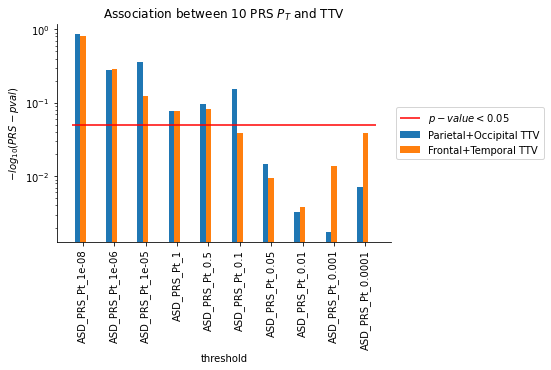

In [79]:
to_plot = mass_univariate[mass_univariate['Connection'].isin(['Frontal+Temporal TTV','Parietal+Occipital TTV'])]
visualisation.SimplePlots.Bar(x=['threshold'],
                             y=['PRS_pval'],hue=['Connection'],data=to_plot,order='x',rotation_x=90,yscalelog=True,hline=0.05,hline_label='$p-value < 0.05$',
                             ylabel='$-log_{10}(PRS-pval)$')
plt.title('Association between 10 PRS $P_T$ and TTV')
sns.despine()
fig.savefig('../../dataset/preprocessed_dataset/asd/output_plot/association_plot_all_Pt.png')

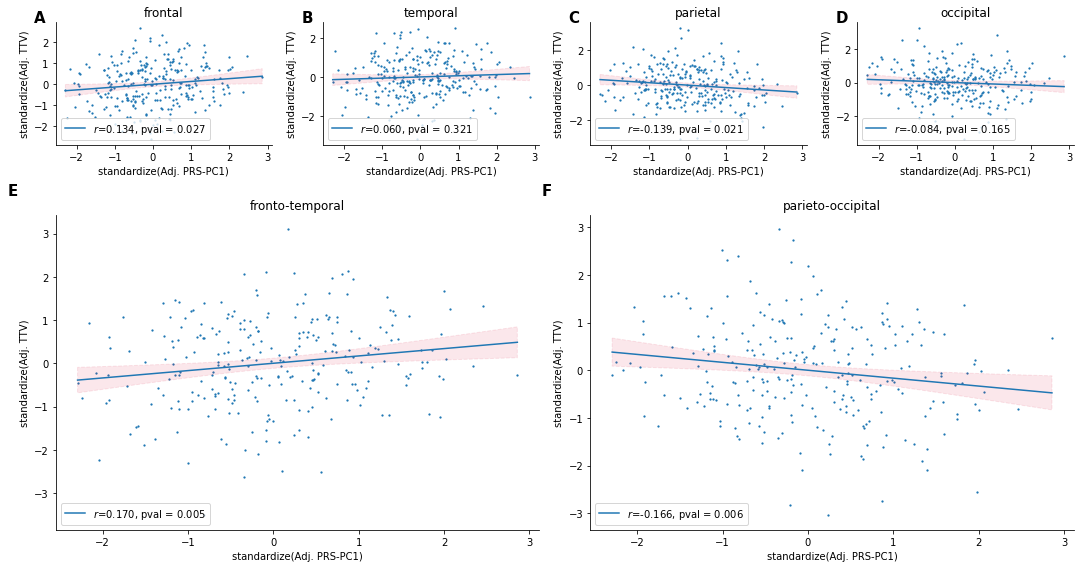

In [43]:
fig = plt.figure(figsize=(15,8))
gs = fig.add_gridspec(3,4)
axes1 = fig.add_subplot(gs[0, 0])
axes2 = fig.add_subplot(gs[0, 1])
axes3 = fig.add_subplot(gs[0, 2])
axes4 = fig.add_subplot(gs[0, 3])
plot1 = fig.add_subplot(gs[1:,0:2])
plot2 = fig.add_subplot(gs[1:,2:])

for ax,title,name,number in zip([axes1,axes2,axes3,axes4,plot1,plot2],
                         ['frontal','temporal','parietal','occipital','fronto-temporal','parieto-occipital'],
                         ['Frontal lobe TTV','Temporal lobe TTV','Parietal lobe TTV','Occipital lobe TTV',
                        'Frontal+Temporal TTV','Parietal+Occipital TTV'],
                               ['A','B','C','D','E','F']):
    visualisation.SimplePlots.Scatter(x='PRS_pca',
                                     y=name,
                                     adjust_covar={'x':ancestry,'y':['sex','GA','PMA','TBV']},
                                     data=new_df,xlabel='PRS-PC1',ylabel='TTV',title=title,ax=ax,legend_loc='lower left')
    ax.text(-0.10, 1.1, number, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top')
sns.despine()
plt.tight_layout()
fig.savefig('../../dataset/preprocessed_dataset/asd/output_plot/scatterplot_full.png')

## AAL atlas

In [5]:
AAL_label = pd.read_excel(open(
    f'{dataset_path}/volumetric/full_dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx',
    'rb'),
                               sheet_name='AAL LEGEND',
                               header=None,names=['AAL_index','AAL_abbrv'])
# Imperial_label.to_csv('./Imperial_label.txt',index=False,header=False)

In [6]:
AAL_label['abbrv'] = AAL_label['AAL_abbrv'].apply(lambda x: x.split(' ')[1].replace("'",''))
AAL_label['index'] = AAL_label['AAL_index'].apply(lambda x: int(x.replace('AAL ','')))

In [7]:
AAL_label_dict = dict((AAL_label[['index','abbrv']].values))

In [8]:
atlas_file = nib.load('../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz')

In [9]:
AAL_label_dict[109] = 'Vermis'

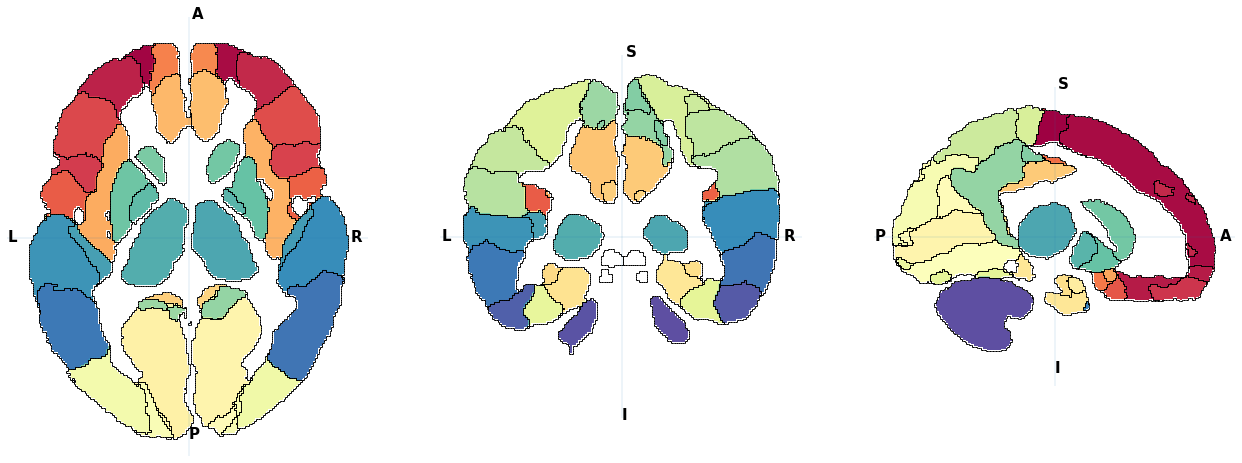

In [20]:
fig,map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['all'],plot_values={i:i for i,v in AAL_label_dict.items()},atlas_slice={'sagittal':120},atlas_file=atlas_file,cmap='Spectral')